Loading in libraries

In [248]:
import pandas as pd
import numpy as np 
import re
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
import re
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF
import decimal
from scipy.stats import kruskal
import statsmodels.api as sm


Loading in the dataframe

In [249]:
df = pd.read_csv("movieReplicationSet.csv")
df

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,0,0
1093,3.0,4.0,NaN,NaN,4.0,4.0,2.5,NaN,3.5,3.5,...,5.0,3.0,5.0,5.0,5.0,6.0,5.0,1.0,0,0
1094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,...,6.0,3.0,1.0,6.0,6.0,4.0,2.0,1.0,0,0
1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,0,1


## Question 1:
Are movies that are more popular (operationalized as having more ratings) rated higher than movies that 
are less popular?

Initial data preprocessing

In [250]:
# Creating a copy of the initial df
df_q1 = df.copy()

# Identify movie columns based on if there's a year in the title
movie_columns = [col for col in df_q1.columns if re.search(r'\(\d{4}\)', col)]

# Subsetting data so that only the movies remain
movie_data_subset = df_q1[movie_columns]

# Counting the non-null ratings for each movie column
ratings_count = movie_data_subset.notnull().sum()

Breaking out the data into separate groups

In [251]:
# Calculate the median count for all ratings
median_ratings_count = ratings_count.median()

# Getting the movie names for movies with high and low counts
high_popularity = ratings_count[ratings_count > median_ratings_count].index.tolist() 
low_popularity = ratings_count[ratings_count <= median_ratings_count].index.tolist()  

Examining the count sizes. Even though the Mann Whitney U test is flexible enough to deal with class imbalances, I believe that this size difference is too large.

In [252]:
# Count the number of ratings (non-null values) for high popularity movies
high_popularity_ratings_count = movie_data_subset[high_popularity].notnull().sum()

# Count the number of ratings (non-null values) for low popularity movies
low_popularity_ratings_count = movie_data_subset[low_popularity].notnull().sum()

# Total ratings count for all high popularity movies
total_high_popularity_ratings = high_popularity_ratings_count.sum()

# Total ratings count for all low popularity movies
total_low_popularity_ratings = low_popularity_ratings_count.sum()

# Outputs
print("Total Ratings Count for High Popularity Movies:", total_high_popularity_ratings)
print("Total Ratings Count for Low Popularity Movies:", total_low_popularity_ratings)

Total Ratings Count for High Popularity Movies: 90214
Total Ratings Count for Low Popularity Movies: 22000


To deal with this heavy class imbalance, I  will be reducing each rating to its median.

In [253]:
# Calculating each movie's median regardless of what group it's in
high_popularity_medians = movie_data_subset[high_popularity].median()
low_popularity_medians = movie_data_subset[low_popularity].median()

Running the hypothesis test

In [254]:
# Mann-Whitney U test
u_stat, p_value_mannwhitney = mannwhitneyu(high_popularity_medians, low_popularity_medians)

# Outputting the results
print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value_mannwhitney}")

Mann-Whitney U test: U-statistic = 33427.5, p-value = 1.9858517703414465e-34


Calculating the Effect Size score

In [255]:
# Use a Cliff's Delta score
delta, interpretation = cliffs_delta(high_popularity_medians, low_popularity_medians)
print(f"Cliff's Delta: {delta} ({interpretation})")

Cliff's Delta: 0.671375 (large)


Examining the distributions through plots

Boxplot

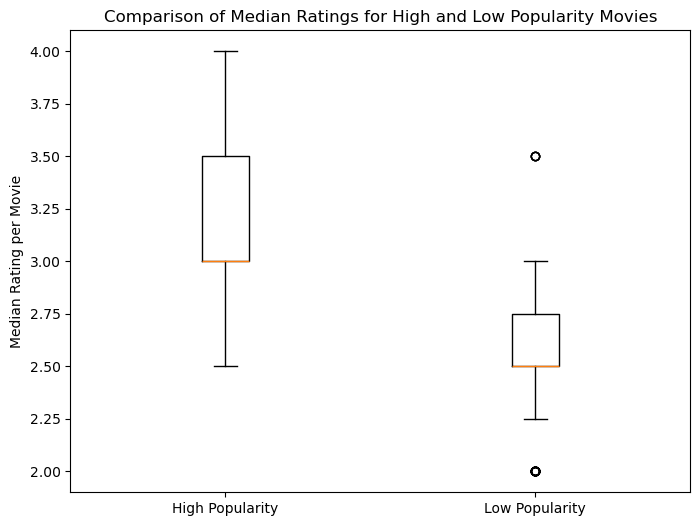

In [256]:
plt.figure(figsize=(8, 6))
plt.boxplot([high_popularity_medians, low_popularity_medians], labels=['High Popularity', 'Low Popularity'])
plt.title("Comparison of Median Ratings for High and Low Popularity Movies")
plt.ylabel("Median Rating per Movie")
plt.show()

Violin Plot

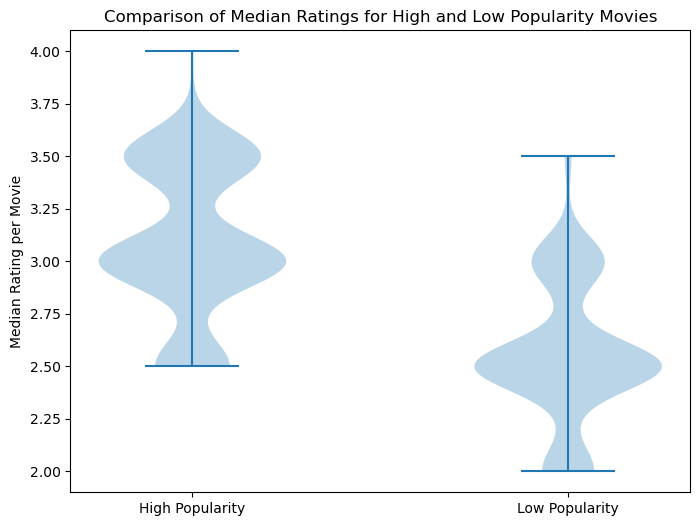

In [257]:
plt.figure(figsize=(8, 6))
plt.violinplot([high_popularity_medians, low_popularity_medians])
plt.title("Comparison of Median Ratings for High and Low Popularity Movies")
plt.ylabel("Median Rating per Movie")
x_positions = [1,2]
x_labels = ["High Popularity", "Low Popularity"]
plt.xticks(x_positions, x_labels)
plt.show()

## Question 2

Are movies that are newer rated differently than movies that are older?

Prepping the data

In [258]:
# creating a copy of the data
df_q2 = df.copy()

# Finding all the movie columns based on if there's a year in the title
movie_columns = [col for col in df_q2.columns if re.search(r'\(\d{4}\)', col)]

In [259]:
# Creating a df of only the movie columns
movie_ratings = df_q2[movie_columns].copy()
movie_ratings.columns = movie_columns

Separating the data based on release years

In [260]:
# Extracting the release years then creating a dictionary where the movie is the key and the year is the value
release_years = {col: int(re.search(r'\((\d{4})\)', col).group(1)) for col in movie_columns}

# Calculating the median of the release years
median_year = pd.Series(list(release_years.values())).median()

# Splitting the movies into older and newer groups based on the median release year
older_movies = [col for col in movie_columns if release_years[col] <= median_year]
newer_movies = [col for col in movie_columns if release_years[col] > median_year]

There is not a large class imbalance

In [261]:
len(older_movies)

226

In [262]:
len(newer_movies)

174

Dealing with the nulls

In [263]:
# Total older ratings
total_ratings_older = df_q2[older_movies].size  
# Total older null ratings
null_ratings_older = df_q2[older_movies].isnull().sum().sum()
null_proportion_older = null_ratings_older / total_ratings_older

# Total new ratings
total_ratings_newer = df_q2[newer_movies].size  
# Total newer null ratings
null_ratings_newer = df_q2[newer_movies].isnull().sum().sum()  
null_proportion_newer = null_ratings_newer / total_ratings_newer

print(f"Null proportion for older movies: {null_proportion_older:.2%}")
print(f"Null proportion for newer movies: {null_proportion_newer:.2%}")

Null proportion for older movies: 77.84%
Null proportion for newer movies: 70.00%


The null proportions are similar, so I feel comfortable dropping the nulls from each group. Time to run the hypothesis test and examine the effect size.

In [264]:
# Flattening the ratings
older_ratings = df_q2[older_movies].stack()
newer_ratings = df_q2[newer_movies].stack()

# Running the Mann-Whitney U test
u_stat, p_value_mannwhitney = mannwhitneyu(older_ratings, newer_ratings, alternative='two-sided')

# Calculating the effect size
delta, interpretation = cliffs_delta(older_ratings, newer_ratings)

print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_value_mannwhitney}")
print(f"Cliff's Delta: {delta} ({interpretation})")

Mann-Whitney U test: U-statistic = 1556898873.0, p-value = 0.0021087243184198757
Cliff's Delta: -0.010441072049244687 (negligible)


Checking out distributions and sizes

In [265]:
# Counting the number of actual reviews
num_reviews_older = df_q2[older_movies].notnull().sum().sum() 
num_reviews_newer = df_q2[newer_movies].notnull().sum().sum()


# Outputs
print(f"Number of Reviews (Older Movies): {num_reviews_older}")
print(f"Number of Reviews (Newer Movies): {num_reviews_newer}")

Number of Reviews (Older Movies): 54948
Number of Reviews (Newer Movies): 57266


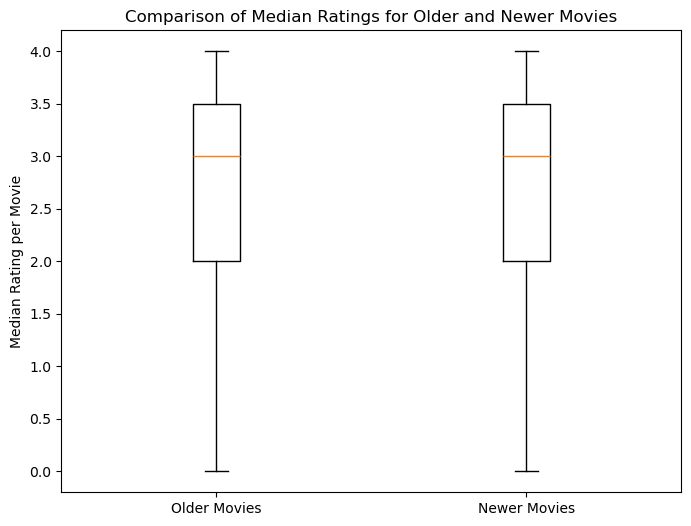

In [266]:
# Plot boxplots for older and newer movie ratings
plt.figure(figsize=(8, 6))
plt.boxplot([older_ratings, newer_ratings], labels=['Older Movies', 'Newer Movies'])
plt.title("Comparison of Median Ratings for Older and Newer Movies")
plt.ylabel("Median Rating per Movie")
plt.show()

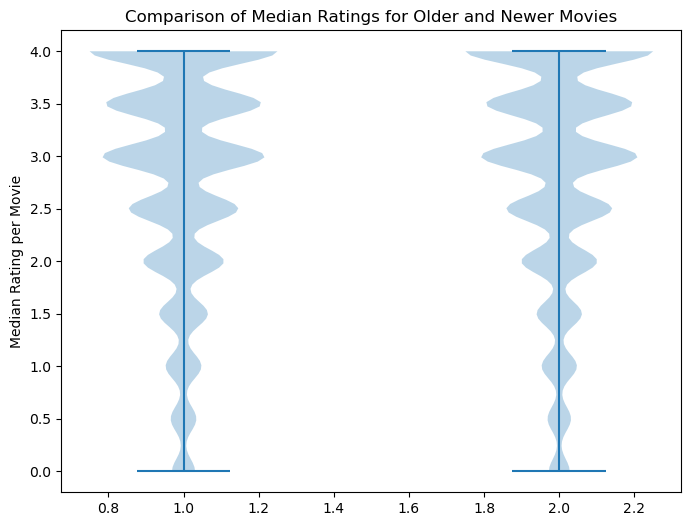

In [267]:
# Violin plot of older and newer movies
plt.figure(figsize=(8, 6))
plt.violinplot([older_ratings, newer_ratings])
plt.title("Comparison of Median Ratings for Older and Newer Movies")
plt.ylabel("Median Rating per Movie")
plt.show()

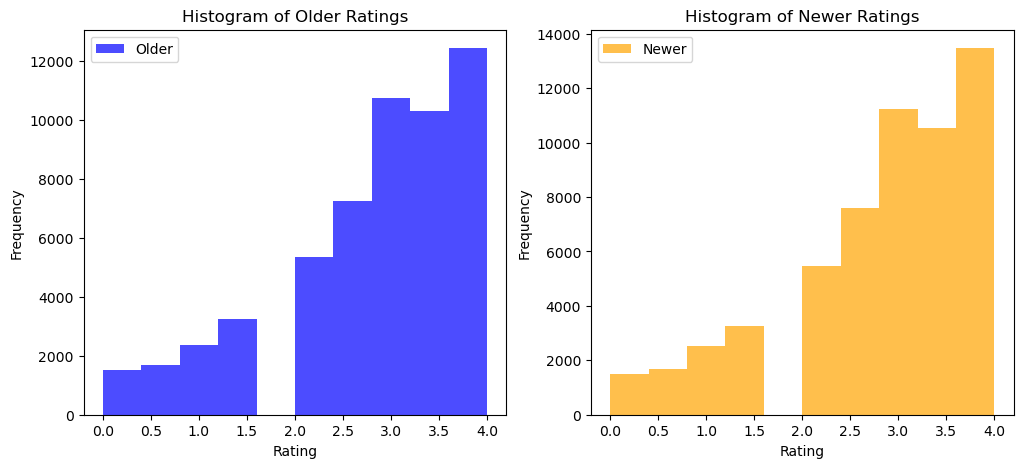

In [268]:
# Histogram of ratings between older and newer movies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(older_ratings, bins=10, color='blue', alpha=0.7, label='Older')
plt.title("Histogram of Older Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(newer_ratings, bins=10, color='orange', alpha=0.7, label='Newer')
plt.title("Histogram of Newer Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

##  Question 3

Is enjoyment of ‘Shrek(2001)’ gendered, i.e. do male and female viewers rate it differently

Prepping the data

In [269]:
# Copying the initial dataset
df_q3 = df.copy()

df_q3

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,0,0
1093,3.0,4.0,NaN,NaN,4.0,4.0,2.5,NaN,3.5,3.5,...,5.0,3.0,5.0,5.0,5.0,6.0,5.0,1.0,0,0
1094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,...,6.0,3.0,1.0,6.0,6.0,4.0,2.0,1.0,0,0
1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,0,1


Checking out null proportions by gender for Shrek

In [270]:
# Calculatiung missing proportions for each subset
male_missing_prop = df_q3.loc[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2, "Shrek (2001)"].isnull().mean()
female_missing_prop = df_q3.loc[df["Gender identity (1 = female; 2 = male; 3 = self-described)"] == 1,"Shrek (2001)"].isnull().mean()

print(f"Proportion of missing values for social watchers: {male_missing_prop:.2%}")
print(f"Proportion of missing values for alone watchers: {female_missing_prop:.2%}")

Proportion of missing values for social watchers: 7.31%
Proportion of missing values for alone watchers: 7.93%


Checking the number of total rows by gender (both including and excluding nulls)

In [271]:
# Check total entries, including NaNs
total_male_ratings = len(df_q3.loc[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2, 'Shrek (2001)'])
non_null_male_ratings = df_q3.loc[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2, 'Shrek (2001)'].dropna().count()

print(f"Total male ratings (including NaNs): {total_male_ratings}")
print(f"Non-null male ratings: {non_null_male_ratings}")


Total male ratings (including NaNs): 260
Non-null male ratings: 241


In [272]:
# Check total entries, including NaNs
total_female_ratings = len(df_q3.loc[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1, 'Shrek (2001)'])
non_null_female_ratings = df_q3.loc[df['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1, 'Shrek (2001)'].dropna().count()

print(f"Total female ratings (including NaNs): {total_female_ratings}")
print(f"Non-null female ratings: {non_null_female_ratings}")

Total female ratings (including NaNs): 807
Non-null female ratings: 743


Mann Whitney U tests are able to deal with class imbalances that we're seeing. Since the null proportions are consistent, I feel comfortable dropping the nulls and running the statistical test.

In [273]:
female_ratings = df_q3.loc[df_q3["Gender identity (1 = female; 2 = male; 3 = self-described)"] ==1, "Shrek (2001)"].dropna()
male_ratings = df_q3.loc[df_q3["Gender identity (1 = female; 2 = male; 3 = self-described)"] == 2, "Shrek (2001)"].dropna()

u_stat, p_value = mannwhitneyu(female_ratings, male_ratings, alternative="two-sided")

# Running a Cliff's Delta for effect size
delta, interpretation = cliffs_delta(female_ratings, male_ratings)


# Outputting the results
print("Mann-Whitney U test for 'Shrek (2001)' by gender:")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")
print(f"Cliff's Delta: {delta} ({interpretation})")


Mann-Whitney U test for 'Shrek (2001)' by gender:
U-statistic: 96830.5
P-value: 0.050536625925559006
Cliff's Delta: 0.08152437968759599 (negligible)


Different plots examining distributions

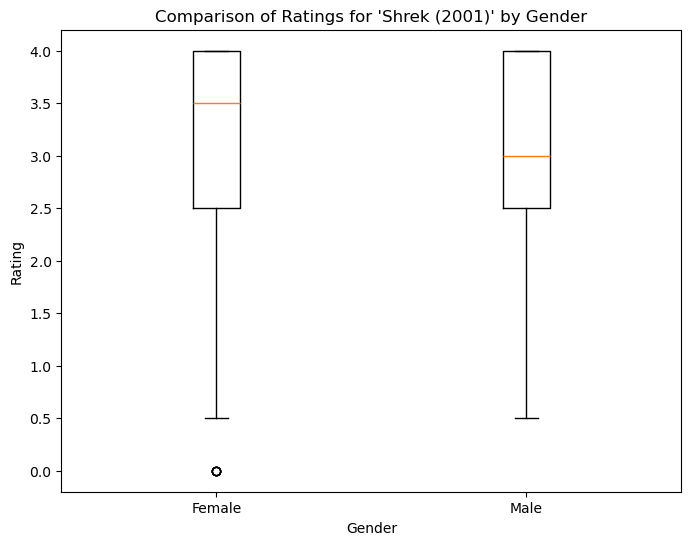

In [274]:
# Boxplots for male and female ratings
plt.figure(figsize=(8, 6))
plt.boxplot([female_ratings, male_ratings], labels=['Female', 'Male'])
plt.title("Comparison of Ratings for 'Shrek (2001)' by Gender")
plt.ylabel("Rating")
plt.xlabel("Gender")
plt.show()


Indicates that the data is not normal

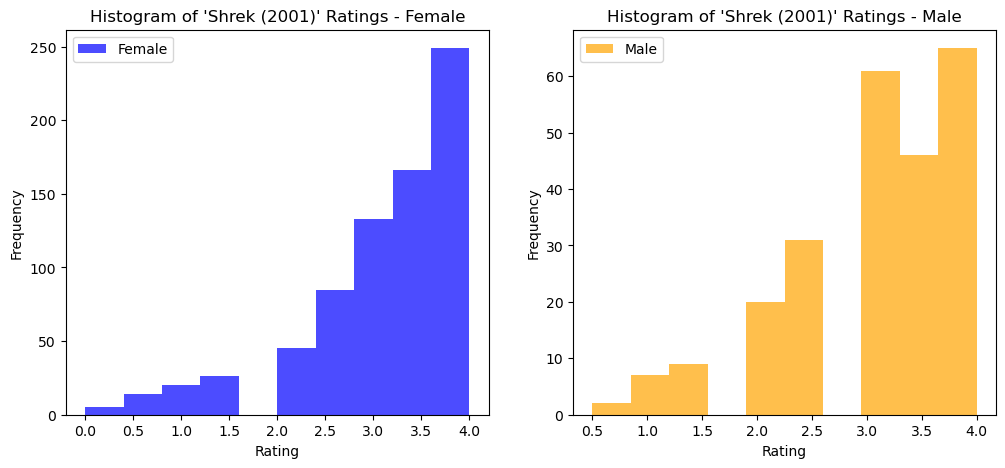

In [275]:
# Histogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(female_ratings, bins=10, color='blue', alpha=0.7, label='Female')
plt.title("Histogram of 'Shrek (2001)' Ratings - Female")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(male_ratings, bins=10, color='orange', alpha=0.7, label='Male')
plt.title("Histogram of 'Shrek (2001)' Ratings - Male")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Using a Shapiro-Wilk test to examine normality. Mann Whitney U test don't assume that the data is normally distributed. This test further proves we should use a Mann Whitney U test.

In [276]:
shapiro_female = stats.shapiro(female_ratings)
shapiro_male = stats.shapiro(male_ratings)

print("Shapiro-Wilk Test Results:")
print(f"Female Ratings: W={shapiro_female[0]}, p-value={shapiro_female[1]}")
print(f"Male Ratings: W={shapiro_male[0]}, p-value={shapiro_male[1]}")

# Interpretation
if shapiro_female[1] > 0.05 and shapiro_male[1] > 0.05:
    print("Both distributions are approximately normal")
else:
    print("One or both distributions deviate from normality")

Shapiro-Wilk Test Results:
Female Ratings: W=0.8399445036717944, p-value=1.1274031379382114e-26
Male Ratings: W=0.8907750321341826, p-value=3.4378632532728826e-12
One or both distributions deviate from normality


## Question 4
What proportion of movies are rated differently by male and female viewers?

Creating a copy of the initial df

In [277]:
df_q4 = df.copy()

Initialize variables

In [278]:
# Significance level we'll be using for the project
alpha = 0.005  
# Dictionary to store p-values for each movie
results = {}  
# Variable that'll hold the number of movies that meet our threshold
significant_movies = 0

In [279]:
# Finding all the movie columns based on if there's a year in the title
movie_columns = [col for col in df_q4.columns if re.search(r'\(\d{4}\)', col)]

Some data preprocessing and then running a Mann Whitney U test

In [280]:
# Loop through each movie column
for column in movie_columns:
    # Calculate missing proportions for each gender
    female_missing = df_q4.loc[df_q4['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1, column].isnull().mean()
    male_missing = df_q4.loc[df_q4['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2, column].isnull().mean()
    
    # Check if missing proportions are similar (10% difference in missing ratings)
    if abs(female_missing - male_missing) < 0.1:
        # Extract non-null ratings by gender
        female_ratings = df_q4.loc[df_q4['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 1, column].dropna()
        male_ratings = df_q4.loc[df_q4['Gender identity (1 = female; 2 = male; 3 = self-described)'] == 2, column].dropna()
        
        # Make sure both genders have a sufficient number of ratings for a robust statistical analysis
        if not female_ratings.empty and not male_ratings.empty:
            if len(female_ratings) >= 10  and len(male_ratings) >= 10:
            # Mann-Whitney U Test
                u_stat, p = mannwhitneyu(female_ratings, male_ratings, alternative='two-sided')
            
            # Store the p-value for each movie
                results[column] = p

            # Count significant differences
                if p < alpha:
                    significant_movies += 1
        else:
            pass

Evaluating Results

In [281]:
# Calculate the proportion of movies rated differently by gender
total_movies = len(results)
proportion_different = significant_movies / total_movies if total_movies > 0 else 0

# Output the results
print(f"Total movies with ratings: {total_movies}")
print(f"Movies rated differently by gender: {significant_movies}")
print(f"Proportion of movies rated differently by gender: {proportion_different:.2%}")

Total movies with ratings: 243
Movies rated differently by gender: 20
Proportion of movies rated differently by gender: 8.23%


Plotting the p-values

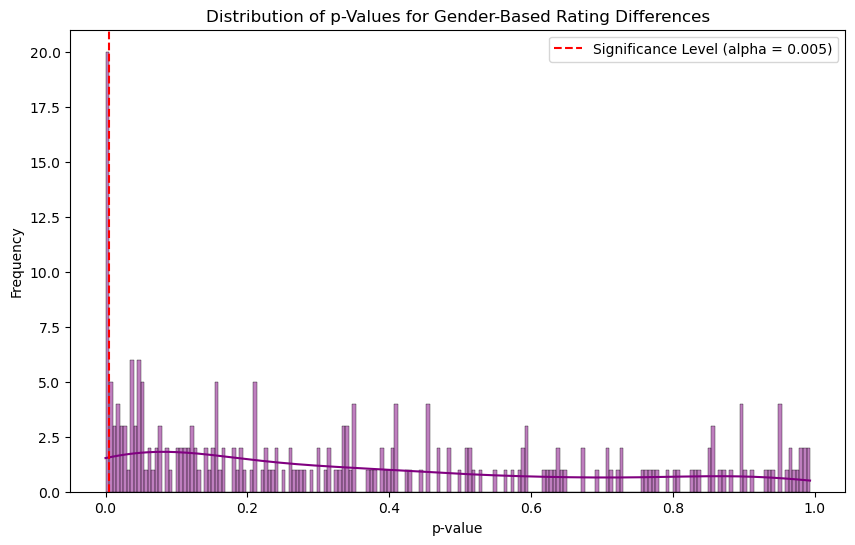

In [282]:
# Convert `results` dictionary to a DataFrame
p_values_df = pd.DataFrame(list(results.items()), columns=['movie', 'p_value'])

# Plot histogram of p-values
plt.figure(figsize=(10, 6))
sns.histplot(p_values_df['p_value'], bins=200, kde=True, color='purple')
plt.axvline(x=alpha, color='red', linestyle='--', label=f'Significance Level (alpha = {alpha})')
plt.title("Distribution of p-Values for Gender-Based Rating Differences")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Question 5
Do people who are only children enjoy ‘The Lion King(1994)’ more than people with siblings?

Initializing the dataframe

In [283]:
df_q5 = df.copy()

Checking out null proportions for each group. The proportions are very similar, so we can drop the nulls later on.

In [284]:
# Calculate missing proportions for each subset
only_missing_prop = df_q5.loc[df_q5['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1, "The Lion King (1994)"].isnull().mean()
sibling_missing_prop = df_q5.loc[df_q5['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0,"The Lion King (1994)"].isnull().mean()

print(f"Proportion of missing values for social watchers: {only_missing_prop:.2%}")
print(f"Proportion of missing values for alone watchers: {sibling_missing_prop:.2%}")

Proportion of missing values for social watchers: 14.69%
Proportion of missing values for alone watchers: 13.20%


Creating the function to turn the data into categorical data

In [285]:
# Specifying the movie
movie_column = "The Lion King (1994)"

# Defining a function that categorizes ratings
def categorize_rating(rating):
    if rating <= 2:
        return 'Low'
    elif rating == 3:
        return 'Medium'
    else:
        return 'High'

Examining the counts from the function

In [286]:
only_child_ratings = df_q5.loc[df_q5["Are you an only child? (1: Yes; 0: No; -1: Did not respond)" ] ==1, movie_column].apply(categorize_rating).value_counts()
only_child_ratings

The Lion King (1994)
High      132
Medium     32
Low        13
Name: count, dtype: int64

In [287]:
siblings_ratings = df_q5.loc[df_q5["Are you an only child? (1: Yes; 0: No; -1: Did not respond)" ] ==0, movie_column].apply(categorize_rating).value_counts()
siblings_ratings

The Lion King (1994)
High      724
Medium    114
Low        56
Name: count, dtype: int64

In [288]:
# Combining the counts into a joint dataframe (as a contigency table)
results = pd.DataFrame({"Only Child Ratings": only_child_ratings, "Sibling Ratings": siblings_ratings}).dropna()
results

,Only Child Ratings,Sibling Ratings
The Lion King (1994),,
High,132,724
Medium,32,114
Low,13,56


Running the Chi Squared test

In [289]:
chi2, p, _, _ = chi2_contingency(results)

In [290]:
# Output the results
print("Chi-Square Test Result for Only Child vs. Sibling Enjoyment of 'The Lion King (1994)':")
print(f"Chi-Square Statistic: {chi2:.3f}")
print(f"p-value: {p:.5f}")
if p < 0.005:
    print("There is a significant difference in enjoyment of 'The Lion King (1994)' based on only-child status.")
else:
    print("There is no significant difference in enjoyment of 'The Lion King (1994)' based on only-child status.")

Chi-Square Test Result for Only Child vs. Sibling Enjoyment of 'The Lion King (1994)':
Chi-Square Statistic: 4.103
p-value: 0.12855
There is no significant difference in enjoyment of 'The Lion King (1994)' based on only-child status.


Creating a bar chart to visualize ratings

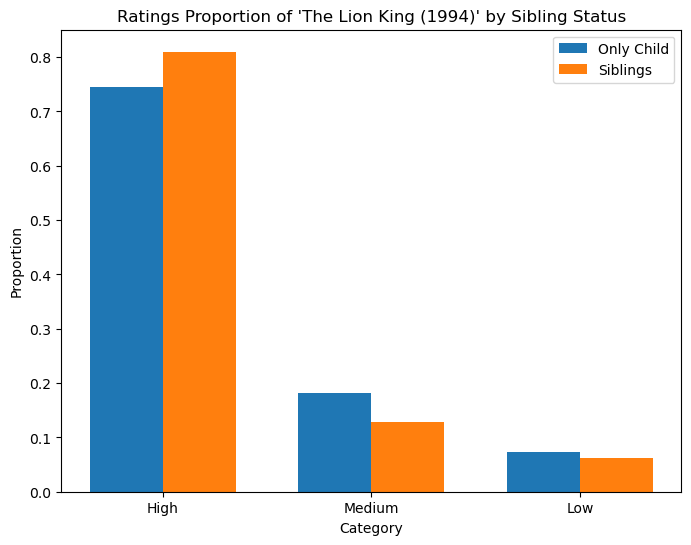

In [291]:
# Setting rating labels
labels = ['High', 'Medium', 'Low']
# Specifying the result counts
only_child_counts = [132/177, 32/177, 13/177]
sibling_counts = [724/894, 114/894, 56/894]

# Adding visualization specifications
x = np.arange(len(labels))
width = 0.35
# Creating the plots
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, only_child_counts, width, label='Only Child')
bars2 = ax.bar(x + width/2, sibling_counts, width, label='Siblings')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Proportion')
ax.set_title("Ratings Proportion of 'The Lion King (1994)' by Sibling Status")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Adding an effect size score using Cramér's V

In [292]:
# Observed counts based on the rows in the contigency table
observed = np.array([[132, 724], [32, 114], [13, 56]])
# Running the Chi Squared test
chi2, p, _, _ = stats.chi2_contingency(observed)
# The sum of each group (only child and siblings)
n = observed.sum()
# Calculating Cramers V
cramers_v = np.sqrt(chi2 / (n * (min(observed.shape) - 1)))

print(f"Cramér's V: {cramers_v:.3f}")

Cramér's V: 0.062


## Question 6
What proportion of movies exhibit an “only child effect”, i.e. are rated different by viewers with siblings vs. those without?

Initializing the dataframe

In [293]:
df_q6 = df.copy()

Initialize variables

In [294]:
# total movies that fit the criteria 
total_movies = 0
# count of movies that have a p-val
different_ratings_count = 0
# Setting significance level
alpha = 0.005  
# Initializing dictionary to store p-values for each movie
results = {}  
# Identify movie columns
movie_columns = [col for col in df_q6.columns if re.search(r'\(\d{4}\)', col)]

Re-using the grouping function

In [295]:
# Group rating into categories
def group_ratings(rating):
    if rating <= 2:
        return 'Low'
    elif rating == 3:
        return 'Medium'
    else:
        return 'High'

Some data filtering then running the statistical test

In [296]:
for column in movie_columns:
    # Calculate missing proportions in each group
    only_child_missing = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1, column].isnull().mean()
    sibling_missing = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0, column].isnull().mean()
    
    # Filter out the movies that have a missing proportion of larger than 10%
    if abs(only_child_missing - sibling_missing) < 0.1:
        # Apply the function and drop nulls
        only_child_ratings = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1, column].dropna().apply(group_ratings).value_counts()
        sibling_ratings = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0, column].dropna().apply(group_ratings).value_counts()

        # Make sure both groups have ratings
        if not only_child_ratings.empty and not sibling_ratings.empty:
            ratings_table = pd.DataFrame({'Only Child Ratings': only_child_ratings, 'Sibling Ratings': sibling_ratings}).fillna(0)

            # Perform the Chi-Square test and get expected counts
            chi2, p, _, expected = chi2_contingency(ratings_table)

            # Filter based on expected counts condition
            if (expected >= 5).all() or ((expected >= 5).sum() >= (expected.size - 1) and (expected >= 1).all()):
                results[column] = p
                if p < alpha:
                    different_ratings_count += 1
                total_movies += 1
    else:
        print(f"Skipped {column} due to imbalanced missingness.")

Skipped Terminator 3: Rise of the Machines (2003) due to imbalanced missingness.
Skipped The Godfather: Part II (1974) due to imbalanced missingness.
Skipped The Iron Giant (1999) due to imbalanced missingness.
Skipped The Matrix Revolutions (2003) due to imbalanced missingness.
Skipped 13 Going on 30 (2004) due to imbalanced missingness.
Skipped Cheaper by the Dozen (2003) due to imbalanced missingness.
Skipped Transformers: Age of Extinction (2014) due to imbalanced missingness.
Skipped Batman (1989) due to imbalanced missingness.
Skipped 10 Things I Hate About You (1999) due to imbalanced missingness.
Skipped Austin Powers: The Spy Who Shagged Me (1999) due to imbalanced missingness.
Skipped A Bug's Life (1998) due to imbalanced missingness.
Skipped Bruce Almighty (2003) due to imbalanced missingness.
Skipped The Mist (2007) due to imbalanced missingness.
Skipped Iron Man 3 (2013) due to imbalanced missingness.
Skipped Captain America: Civil War (2016) due to imbalanced missingness.

In [297]:
# Calculate the proportion of movies rated differently based on only-child status
proportion_different = different_ratings_count / total_movies if total_movies > 0 else 0

# Output
print(f"Total movies with ratings: {total_movies}")
print(f"Movies rated differently based on only-child status: {different_ratings_count}")
print(f"Proportion of movies rated differently by only-child status: {proportion_different:.2%}")


Total movies with ratings: 348
Movies rated differently based on only-child status: 5
Proportion of movies rated differently by only-child status: 1.44%


Contigency table example

In [298]:
ratings_table

,Only Child Ratings,Sibling Ratings
Look Who's Talking (1989),,
High,4,39
Low,14,31
Medium,1,17


Printing out each missingness proportion from above

In [299]:
# Calculate missing proportions for each movie by group (only children and siblings)
for column in movie_columns:
    only_child_missing = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 1, column].isnull().mean()
    sibling_missing = df_q6.loc[df_q6['Are you an only child? (1: Yes; 0: No; -1: Did not respond)'] == 0, column].isnull().mean()
    
    print(f"Missing proportion for only children in {column}: {only_child_missing:.2%}")
    print(f"Missing proportion for siblings in {column}: {sibling_missing:.2%}")
    print("\n") 


Missing proportion for only children in The Life of David Gale (2003): 90.40%
Missing proportion for siblings in The Life of David Gale (2003): 93.85%


Missing proportion for only children in Wing Commander (1999): 91.53%
Missing proportion for siblings in Wing Commander (1999): 93.96%


Missing proportion for only children in Django Unchained (2012): 56.50%
Missing proportion for siblings in Django Unchained (2012): 59.62%


Missing proportion for only children in Alien (1979): 69.49%
Missing proportion for siblings in Alien (1979): 74.61%


Missing proportion for only children in Indiana Jones and the Last Crusade (1989): 57.06%
Missing proportion for siblings in Indiana Jones and the Last Crusade (1989): 58.39%


Missing proportion for only children in Snatch (2000): 86.44%
Missing proportion for siblings in Snatch (2000): 88.93%


Missing proportion for only children in Rambo: First Blood Part II (1985): 80.23%
Missing proportion for siblings in Rambo: First Blood Part II (1985): 

## Question 7 
Do people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who preferto watch them alone?

Initialize the df

In [300]:
df_q7 = df.copy()

Calculating missingness proportions

In [301]:
# Calculate missing proportions for each subset
social_missing_prop = df_q7.loc[df_q7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1, movie_column].isnull().mean()
alone_missing_prop = df_q7.loc[df_q7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0, movie_column].isnull().mean()

print(f"Proportion of missing values for social watchers: {social_missing_prop:.2%}")
print(f"Proportion of missing values for alone watchers: {alone_missing_prop:.2%}")

Proportion of missing values for social watchers: 14.92%
Proportion of missing values for alone watchers: 11.47%


Dropping nulls and examining the resulting counts

In [302]:
# Extract ratings
social_watchers = df_q7.loc[df_q7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1, 'The Wolf of Wall Street (2013)'].dropna()
alone_watchers = df_q7.loc[df_q7['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0, 'The Wolf of Wall Street (2013)'].dropna()

In [303]:
print(f"Number of ratings for social watchers: {len(social_watchers)}")
print(f"Number of ratings for alone watchers: {len(alone_watchers)}")

Number of ratings for social watchers: 393
Number of ratings for alone watchers: 270


The Mann Whitney U test can handle this level of imbalanced classes

In [304]:
# Perform the Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(social_watchers, alone_watchers, alternative='two-sided')

print(f"Mann-Whitney U test for 'The Wolf of Wall Street' by social watching preference")
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value}")

Mann-Whitney U test for 'The Wolf of Wall Street' by social watching preference
U-statistic: 56806.5
p-value: 0.1127642933222891


Adding an effect size test

In [305]:
# Cliff's Delta for effect size
delta, interpretation = cliffs_delta(social_watchers, alone_watchers)

# Output the results 
print(f"Cliff's Delta: {delta} ({interpretation})")

Cliff's Delta: 0.07070964093864857 (negligible)


Creating visualization

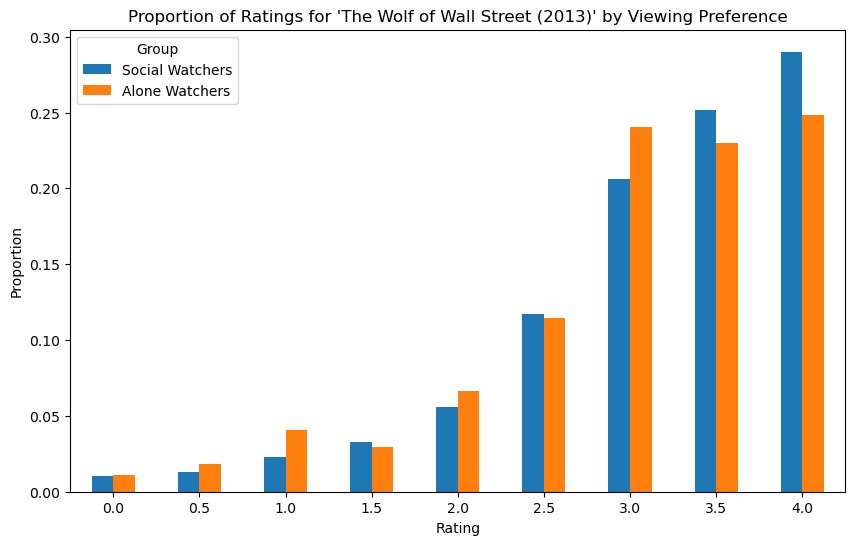

In [306]:
# Calculate proportions for each rating within each group
social_counts = pd.Series(social_watchers).value_counts(normalize=True).sort_index()
alone_counts = pd.Series(alone_watchers).value_counts(normalize=True).sort_index()

# Combine into a DataFrame for easier plotting
proportions_df = pd.DataFrame({
    'Social Watchers': social_counts,
    'Alone Watchers': alone_counts
}).dropna()

# Plotting the clustered bar chart
proportions_df.plot(kind='bar', figsize=(10, 6))
plt.title("Proportion of Ratings for 'The Wolf of Wall Street (2013)' by Viewing Preference")
plt.xlabel("Rating")
plt.ylabel("Proportion")
plt.legend(title="Group")
plt.xticks(rotation=0)
plt.show()


## Question 8
What proportion of movies exhibit such a “social watching” effect?

Initialize the dataframe

In [307]:
df_q8 = df.copy()

Initialize variables

In [308]:
# Set the significance level
alpha = 0.005  
# Dictionary to store p-values for each movie
results = {}  
# Initialize the count of movies that show statistically significant differences
significant_movies = 0
# Identify movie columns
movie_columns = [col for col in df_q8.columns if re.search(r'\(\d{4}\)', col)]

Data filtering and running the test

In [309]:
# Loop through each movie column identified
for column in movie_columns:
    # Calculate missing proportions for social watchers and alone watchers
    social_missing = df_q8.loc[df_q8['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1, column].isnull().mean()
    alone_missing = df_q8.loc[df_q8['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0, column].isnull().mean()
    
    # Check if missing proportions are within 10%. Filter out the ratins that have higher missing proportions 
    if abs(social_missing - alone_missing) < 0.1:
        # Extract non-null ratings for social and alone watchers
        social_ratings = df_q8.loc[df_q8['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 1, column].dropna()
        alone_ratings = df_q8.loc[df_q8['Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'] == 0, column].dropna()
        
        # Ensure both groups have a minimum of 10 ratings for reliability
        if len(social_ratings) >= 10 and len(alone_ratings) >= 10:
            # Perform the Mann-Whitney U Test
            u_stat, p = mannwhitneyu(social_ratings, alone_ratings, alternative='two-sided')
            
            # Store the p-value for each movie
            results[column] = p

            # Count significant differences
            if p < alpha:
                significant_movies += 1
    else:
        print(f"Skipped {column} due to imbalanced missingness between groups.")

Skipped The Shining (1980) due to imbalanced missingness between groups.


In [310]:
# Calculate the proportion of movies rated differently by social watching preference
total_movies = len(results)
proportion_different = significant_movies / total_movies if total_movies > 0 else 0

# Output the results
print(f"Total movies with ratings: {total_movies}")
print(f"Movies rated differently by social watching preference: {significant_movies}")
print(f"Proportion of movies with a social watching effect: {proportion_different:.2%}")


Total movies with ratings: 399
Movies rated differently by social watching preference: 10
Proportion of movies with a social watching effect: 2.51%


Creating the visualization

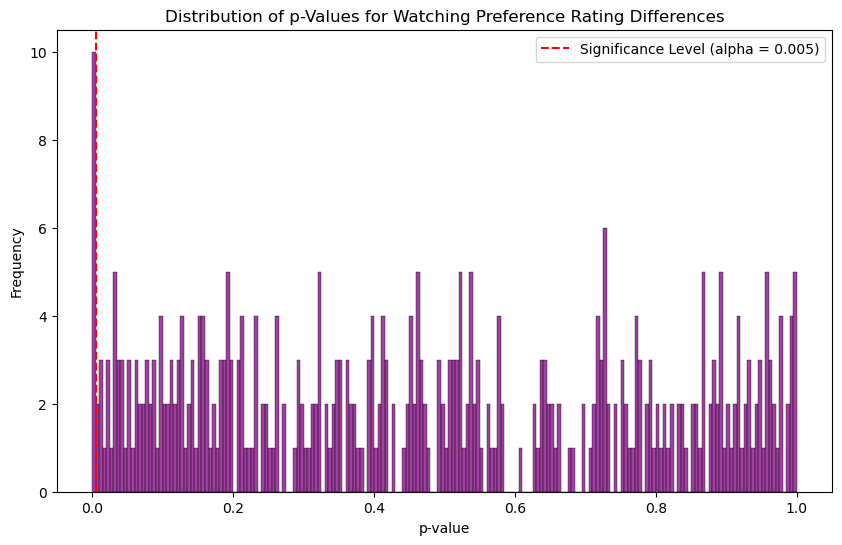

In [311]:
# Storing all the p-values in a dataframe
p_values_df = pd.DataFrame(list(results.items()), columns=['movie', 'p_value'])

# Define the significance level 
alpha = 0.005

# Plot histogram of p-values
plt.figure(figsize=(10, 6))
sns.histplot(p_values_df['p_value'], bins=200, color='purple')
plt.axvline(x=alpha, color='red', linestyle='--', label=f'Significance Level (alpha = {alpha})')
plt.title("Distribution of p-Values for Watching Preference Rating Differences")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Question 9
Is the ratings distribution of ‘Home Alone (1990)’ different than that of ‘Finding Nemo (2003)?

In [312]:
# Initialize the dataframe
df_q9 = df.copy()

Examining distributions, counts, and nulls

<Axes: >

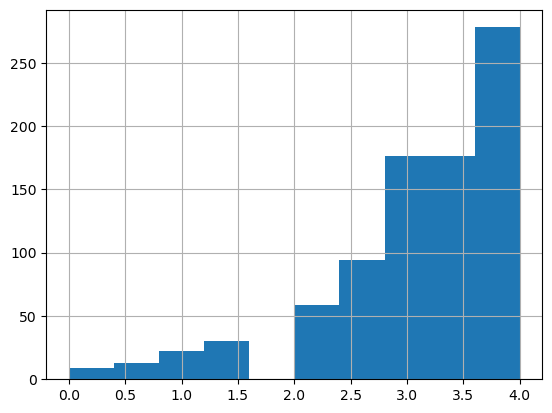

In [313]:
# Histogram of home alone ratings
ratings_home_alone = df_q9["Home Alone (1990)"]
ratings_home_alone.hist()

In [314]:
# Number of null ratings in home alone
ratings_home_alone.isnull().sum()

240

<Axes: >

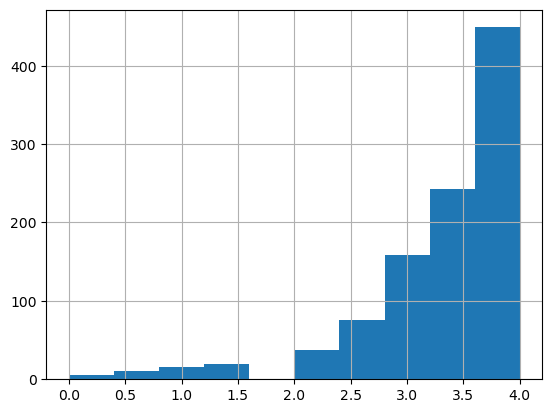

In [315]:
# Finding nemo rating histogram
ratings_finding_nemo = df_q9["Finding Nemo (2003)"]
ratings_finding_nemo.hist()

In [316]:
# Number of null ratings in finding nemo
ratings_finding_nemo.isnull().sum()

83

In [317]:
# Value counts for home alone ratings
ratings_home_alone.value_counts()

Home Alone (1990)
4.0    278
3.5    176
3.0    176
2.5     94
2.0     59
1.5     30
1.0     22
0.5     13
0.0      9
Name: count, dtype: int64

In [318]:
# Value counts for finding nemo ratings
ratings_finding_nemo.value_counts()

Finding Nemo (2003)
4.0    449
3.5    243
3.0    158
2.5     76
2.0     37
1.5     20
1.0     16
0.5     10
0.0      5
Name: count, dtype: int64

In [319]:
# Total number of rows for home alone
len(ratings_home_alone)

1097

In [320]:
# Total number of rows for finding nemo
len(ratings_finding_nemo)

1097

In [321]:
# Function to calculate null proportions for each movie
def calculate_null_proportion(ratings):
    total_ratings = len(ratings)
    null_ratings = ratings.isnull().sum()
    null_proportion = null_ratings / total_ratings

    return null_proportion

Applying the function for each movie

In [322]:
home_alone_null_proportion = calculate_null_proportion(ratings_home_alone)
print(home_alone_null_proportion)

0.2187784867821331


In [323]:
finding_nemo_null_proportion = calculate_null_proportion(ratings_finding_nemo)
print(finding_nemo_null_proportion)

0.07566089334548769


The null proportions are considerably different. I'm hesitant to drop nulls, so I'll try to include imputed values to see how that changes the results.

In [324]:
# Run KS test with dropping nulls
ks_stat, p_value = ks_2samp(ratings_home_alone.dropna(), ratings_finding_nemo.dropna())

# Outputting
print("KS Test Statistic:", ks_stat)
print("p-value (exact):", decimal.Decimal(p_value))

KS Test Statistic: 0.15269080020897632
p-value (exact): 6.3793971828363462426724731459321861282152354988284059800207614898681640625E-10


Examining the resulting number of rows (ratings) for each movie

In [325]:
ratings_finding_nemo.count()

1014

In [326]:
ratings_home_alone.count()

857

Running the KS test with dropping nulls and median imputing them

In [327]:
# KS Test with nulls dropped
ks_stat_no_nulls, p_value_no_nulls = ks_2samp(ratings_home_alone.dropna(), ratings_finding_nemo.dropna())
print("Without Nulls:")
print(f"KS Test Statistic: {ks_stat_no_nulls:.4f}")
print(f"p-value: {p_value_no_nulls:.20f}")

# Simple median imputation
home_alone_imputed = ratings_home_alone.fillna(ratings_home_alone.median())
finding_nemo_imputed = ratings_finding_nemo.fillna(ratings_finding_nemo.median())

# KS Test with simple imputation
ks_stat_imputed, p_value_imputed = ks_2samp(home_alone_imputed, finding_nemo_imputed)
print("\nWith Simple Imputation (median):")
print(f"KS Test Statistic: {ks_stat_imputed:.4f}")
print(f"p-value: {p_value_imputed:.20f}")

# Interpret the results
if p_value_no_nulls < 0.05 and p_value_imputed < 0.05:
    print("Both tests indicate a significant difference in distribution.")
elif p_value_no_nulls >= 0.05 and p_value_imputed >= 0.05:
    print("Both tests indicate no significant difference in distribution.")
else:
    print("Results are sensitive to the treatment of missing data.")


Without Nulls:
KS Test Statistic: 0.1527
p-value: 0.00000000063793971828

With Simple Imputation (median):
KS Test Statistic: 0.1559
p-value: 0.00000000000481641162
Both tests indicate a significant difference in distribution.


The statistical test results are extremely similar. Since the data for this project is user ratings, I don't want to impute results if I don't need to. I'll be using the dropped nulls subset moving forward.

Here's some data visualizations

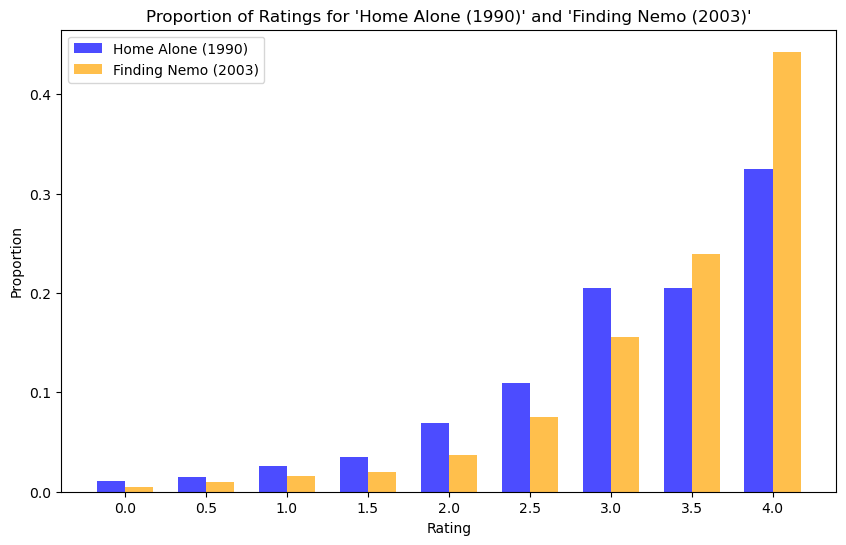

In [328]:
# Calculate proportions for each rating
ratings_home_alone_counts = ratings_home_alone.value_counts(normalize=True).sort_index()
ratings_finding_nemo_counts = ratings_finding_nemo.value_counts(normalize=True).sort_index()

# Bar width and index for the clustered chart
bar_width = 0.35
index = np.arange(len(ratings_home_alone_counts))

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(index, ratings_home_alone_counts, bar_width, label='Home Alone (1990)', color='blue', alpha=0.7)
plt.bar(index + bar_width, ratings_finding_nemo_counts, bar_width, label='Finding Nemo (2003)', color='orange', alpha=0.7)

# Labels and title
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.title("Proportion of Ratings for 'Home Alone (1990)' and 'Finding Nemo (2003)'")
plt.xticks(index + bar_width / 2, ratings_home_alone_counts.index)
plt.legend()
plt.show()


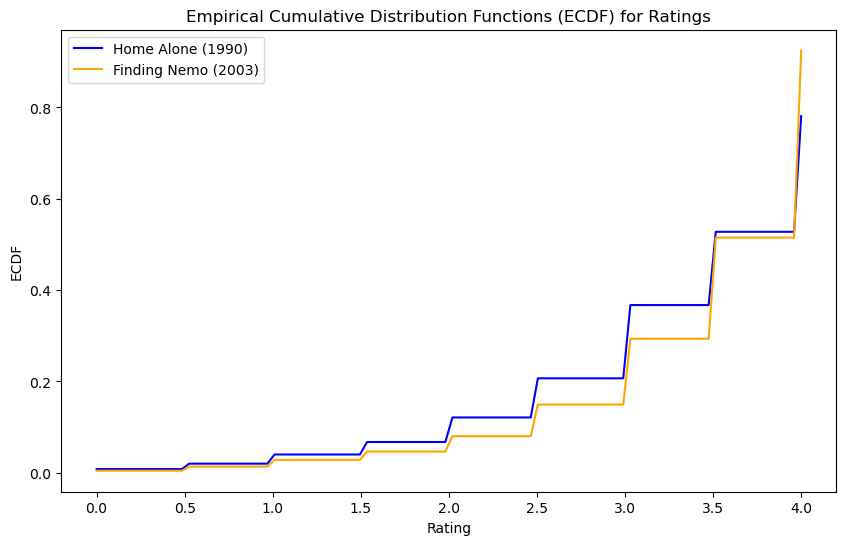

In [329]:
# Calculate ECDFs
ecdf_home_alone = ECDF(ratings_home_alone)
ecdf_finding_nemo = ECDF(ratings_finding_nemo)

# Generate a range of values for plotting the CDFs
x_vals = np.linspace(min(ratings_home_alone.min(), ratings_finding_nemo.min()), 
                     max(ratings_home_alone.max(), ratings_finding_nemo.max()), 
                     100)

# Plot ECDFs
plt.figure(figsize=(10, 6))
plt.plot(x_vals, ecdf_home_alone(x_vals), label='Home Alone (1990)', color='blue')
plt.plot(x_vals, ecdf_finding_nemo(x_vals), label='Finding Nemo (2003)', color='orange')

# Add labels and legend
plt.title("Empirical Cumulative Distribution Functions (ECDF) for Ratings")
plt.xlabel("Rating")
plt.ylabel("ECDF")
plt.legend()
plt.show()


We can see how the ratings for each movie appear to be considerably different. Finding Nemo's ratings tend to be higher while Home Alone's ratings tend to be lower.

Calculating an effect size

In [330]:
# Calculating Cliffs Delta
delta, interpretation = cliffs_delta(ratings_home_alone, ratings_finding_nemo)

print(f"Cliff's Delta: {delta:.4f} ({interpretation})")

Cliff's Delta: -0.9674 (large)


## Question 10
There are ratings on movies from several franchises ([‘Star Wars’, ‘Harry Potter’, ‘The Matrix’, ‘Indiana Jones’, ‘Jurassic Park’, ‘Pirates of the Caribbean’, ‘Toy Story’, ‘Batman’]) in this dataset. How many of these  are of inconsistent quality, as experienced by viewers?

Initializing the df

In [331]:
df_10 = df.copy()

Adding every movie to its relevant franchise

In [332]:
# Dictionary to store movies by franchise
franchises = {
    'Star Wars': [],
    'Harry Potter': [],
    'The Matrix': [],
    'Indiana Jones': [],
    'Jurassic Park': [],
    'Pirates of the Caribbean': [],
    'Toy Story': [],
    'Batman': []
}

# Loop through each column name to assign movies to franchises
# movie_columns is the filtering column subset of every movie
for column in movie_columns:
    for franchise in franchises:
        if franchise in column:
            franchises[franchise].append(column)

# Display the organized franchise movies
for franchise, movies in franchises.items():
    print(f"{franchise}: {movies}")


Star Wars: ['Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode II - Attack of the Clones (2002)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode 1 - The Phantom Menace (1999)', 'Star Wars: Episode VII - The Force Awakens (2015)', 'Star Wars: Episode VI - The Return of the Jedi (1983)']
Harry Potter: ["Harry Potter and the Sorcerer's Stone (2001)", 'Harry Potter and the Deathly Hallows: Part 2 (2011)', 'Harry Potter and the Goblet of Fire (2005)', 'Harry Potter and the Chamber of Secrets (2002)']
The Matrix: ['The Matrix Revolutions (2003)', 'The Matrix Reloaded (2003)', 'The Matrix (1999)']
Indiana Jones: ['Indiana Jones and the Last Crusade (1989)', 'Indiana Jones and the Temple of Doom (1984)', 'Indiana Jones and the Raiders of the Lost Ark (1981)', 'Indiana Jones and the Kingdom of the Crystal Skull (2008)']
Jurassic Park: ['The Lost World: Jurassic Park (1997)', 'Jurassic Park III (2001)', 'Jurassic Park (1993)']
Pirates of the Caribbean:

Calculating null proportions for each movie

In [333]:
# Dictionary to store each null proportion by movie
null_proportions = {}

# Calculating the null proportions
for franchise, movies in franchises.items():
    franchise_nulls = {}
    for movie in movies:
        null_proportion = df_10[movie].isnull().mean()
        franchise_nulls[movie] = null_proportion
    null_proportions[franchise] = franchise_nulls

# Display the null proportions
for franchise, movie_nulls in null_proportions.items():
    print(f"Null Proportions for {franchise} Franchise:")
    for movie, null_prop in movie_nulls.items():
        print(f"{movie}: {null_prop:.2%}")
    print("\n")

Null Proportions for Star Wars Franchise:
Star Wars: Episode IV - A New Hope (1977): 50.23%
Star Wars: Episode II - Attack of the Clones (2002): 51.41%
Star Wars: Episode V - The Empire Strikes Back (1980): 55.42%
Star Wars: Episode 1 - The Phantom Menace (1999): 58.71%
Star Wars: Episode VII - The Force Awakens (2015): 55.79%
Star Wars: Episode VI - The Return of the Jedi (1983): 58.71%


Null Proportions for Harry Potter Franchise:
Harry Potter and the Sorcerer's Stone (2001): 20.69%
Harry Potter and the Deathly Hallows: Part 2 (2011): 24.34%
Harry Potter and the Goblet of Fire (2005): 25.80%
Harry Potter and the Chamber of Secrets (2002): 22.88%


Null Proportions for The Matrix Franchise:
The Matrix Revolutions (2003): 65.91%
The Matrix Reloaded (2003): 69.37%
The Matrix (1999): 54.69%


Null Proportions for Indiana Jones Franchise:
Indiana Jones and the Last Crusade (1989): 57.79%
Indiana Jones and the Temple of Doom (1984): 56.15%
Indiana Jones and the Raiders of the Lost Ark (19

Calculating total ratings by movie

In [334]:
# Dictionary to count ratings by movie
movie_counts = {}

# Calculating the number of ratings by movie
for franchise, movies in franchises.items():
    franchise_counts = {}
    for movie in movies:
        count = df_10[movie].count() 
        franchise_counts[movie] = count
    movie_counts[franchise] = franchise_counts

# Display the counts
for franchise, counts in movie_counts.items():
    print(f"Non-Null Counts for {franchise} Franchise:")
    for movie, count in counts.items():
        print(f"{movie}: {count} ratings")
    print("\n")

Non-Null Counts for Star Wars Franchise:
Star Wars: Episode IV - A New Hope (1977): 546 ratings
Star Wars: Episode II - Attack of the Clones (2002): 533 ratings
Star Wars: Episode V - The Empire Strikes Back (1980): 489 ratings
Star Wars: Episode 1 - The Phantom Menace (1999): 453 ratings
Star Wars: Episode VII - The Force Awakens (2015): 485 ratings
Star Wars: Episode VI - The Return of the Jedi (1983): 453 ratings


Non-Null Counts for Harry Potter Franchise:
Harry Potter and the Sorcerer's Stone (2001): 870 ratings
Harry Potter and the Deathly Hallows: Part 2 (2011): 830 ratings
Harry Potter and the Goblet of Fire (2005): 814 ratings
Harry Potter and the Chamber of Secrets (2002): 846 ratings


Non-Null Counts for The Matrix Franchise:
The Matrix Revolutions (2003): 374 ratings
The Matrix Reloaded (2003): 336 ratings
The Matrix (1999): 497 ratings


Non-Null Counts for Indiana Jones Franchise:
Indiana Jones and the Last Crusade (1989): 463 ratings
Indiana Jones and the Temple of Doo

Testing for statistical significance

In [335]:
# Dictionary to store results of inconsistency for each franchise
inconsistency_results = {}

# Loop through each franchise to perform the Kruskal-Wallis test
for franchise, movies in franchises.items():
    # Store non-null ratings for each movie in the franchise
    franchise_ratings = [df_10[movie].dropna() for movie in movies]

    # Perform Kruskal-Wallis test to test for consistency
    if len(franchise_ratings) > 1:
        kruskal_stat, p_value = kruskal(*franchise_ratings)
        inconsistency_results[franchise] = (kruskal_stat, p_value)

# Summary of inconsistency results
print("Inconsistency Results Summary:")
for franchise, (stat, p_val) in inconsistency_results.items():
    consistency = "Inconsistent" if p_val < 0.005 else "Consistent"
    print(f"{franchise}: {consistency} (p = {(p_val)})")


Inconsistency Results Summary:
Star Wars: Inconsistent (p = 8.01647736660335e-48)
Harry Potter: Consistent (p = 0.34331950837289205)
The Matrix: Inconsistent (p = 3.1236517880781424e-11)
Indiana Jones: Inconsistent (p = 6.27277563979608e-10)
Jurassic Park: Inconsistent (p = 7.636930084362221e-11)
Pirates of the Caribbean: Inconsistent (p = 3.2901287079094474e-05)
Toy Story: Inconsistent (p = 5.065805156537524e-06)
Batman: Inconsistent (p = 4.2252969509030006e-42)


Plotting the ratings proportions by franchise and movie

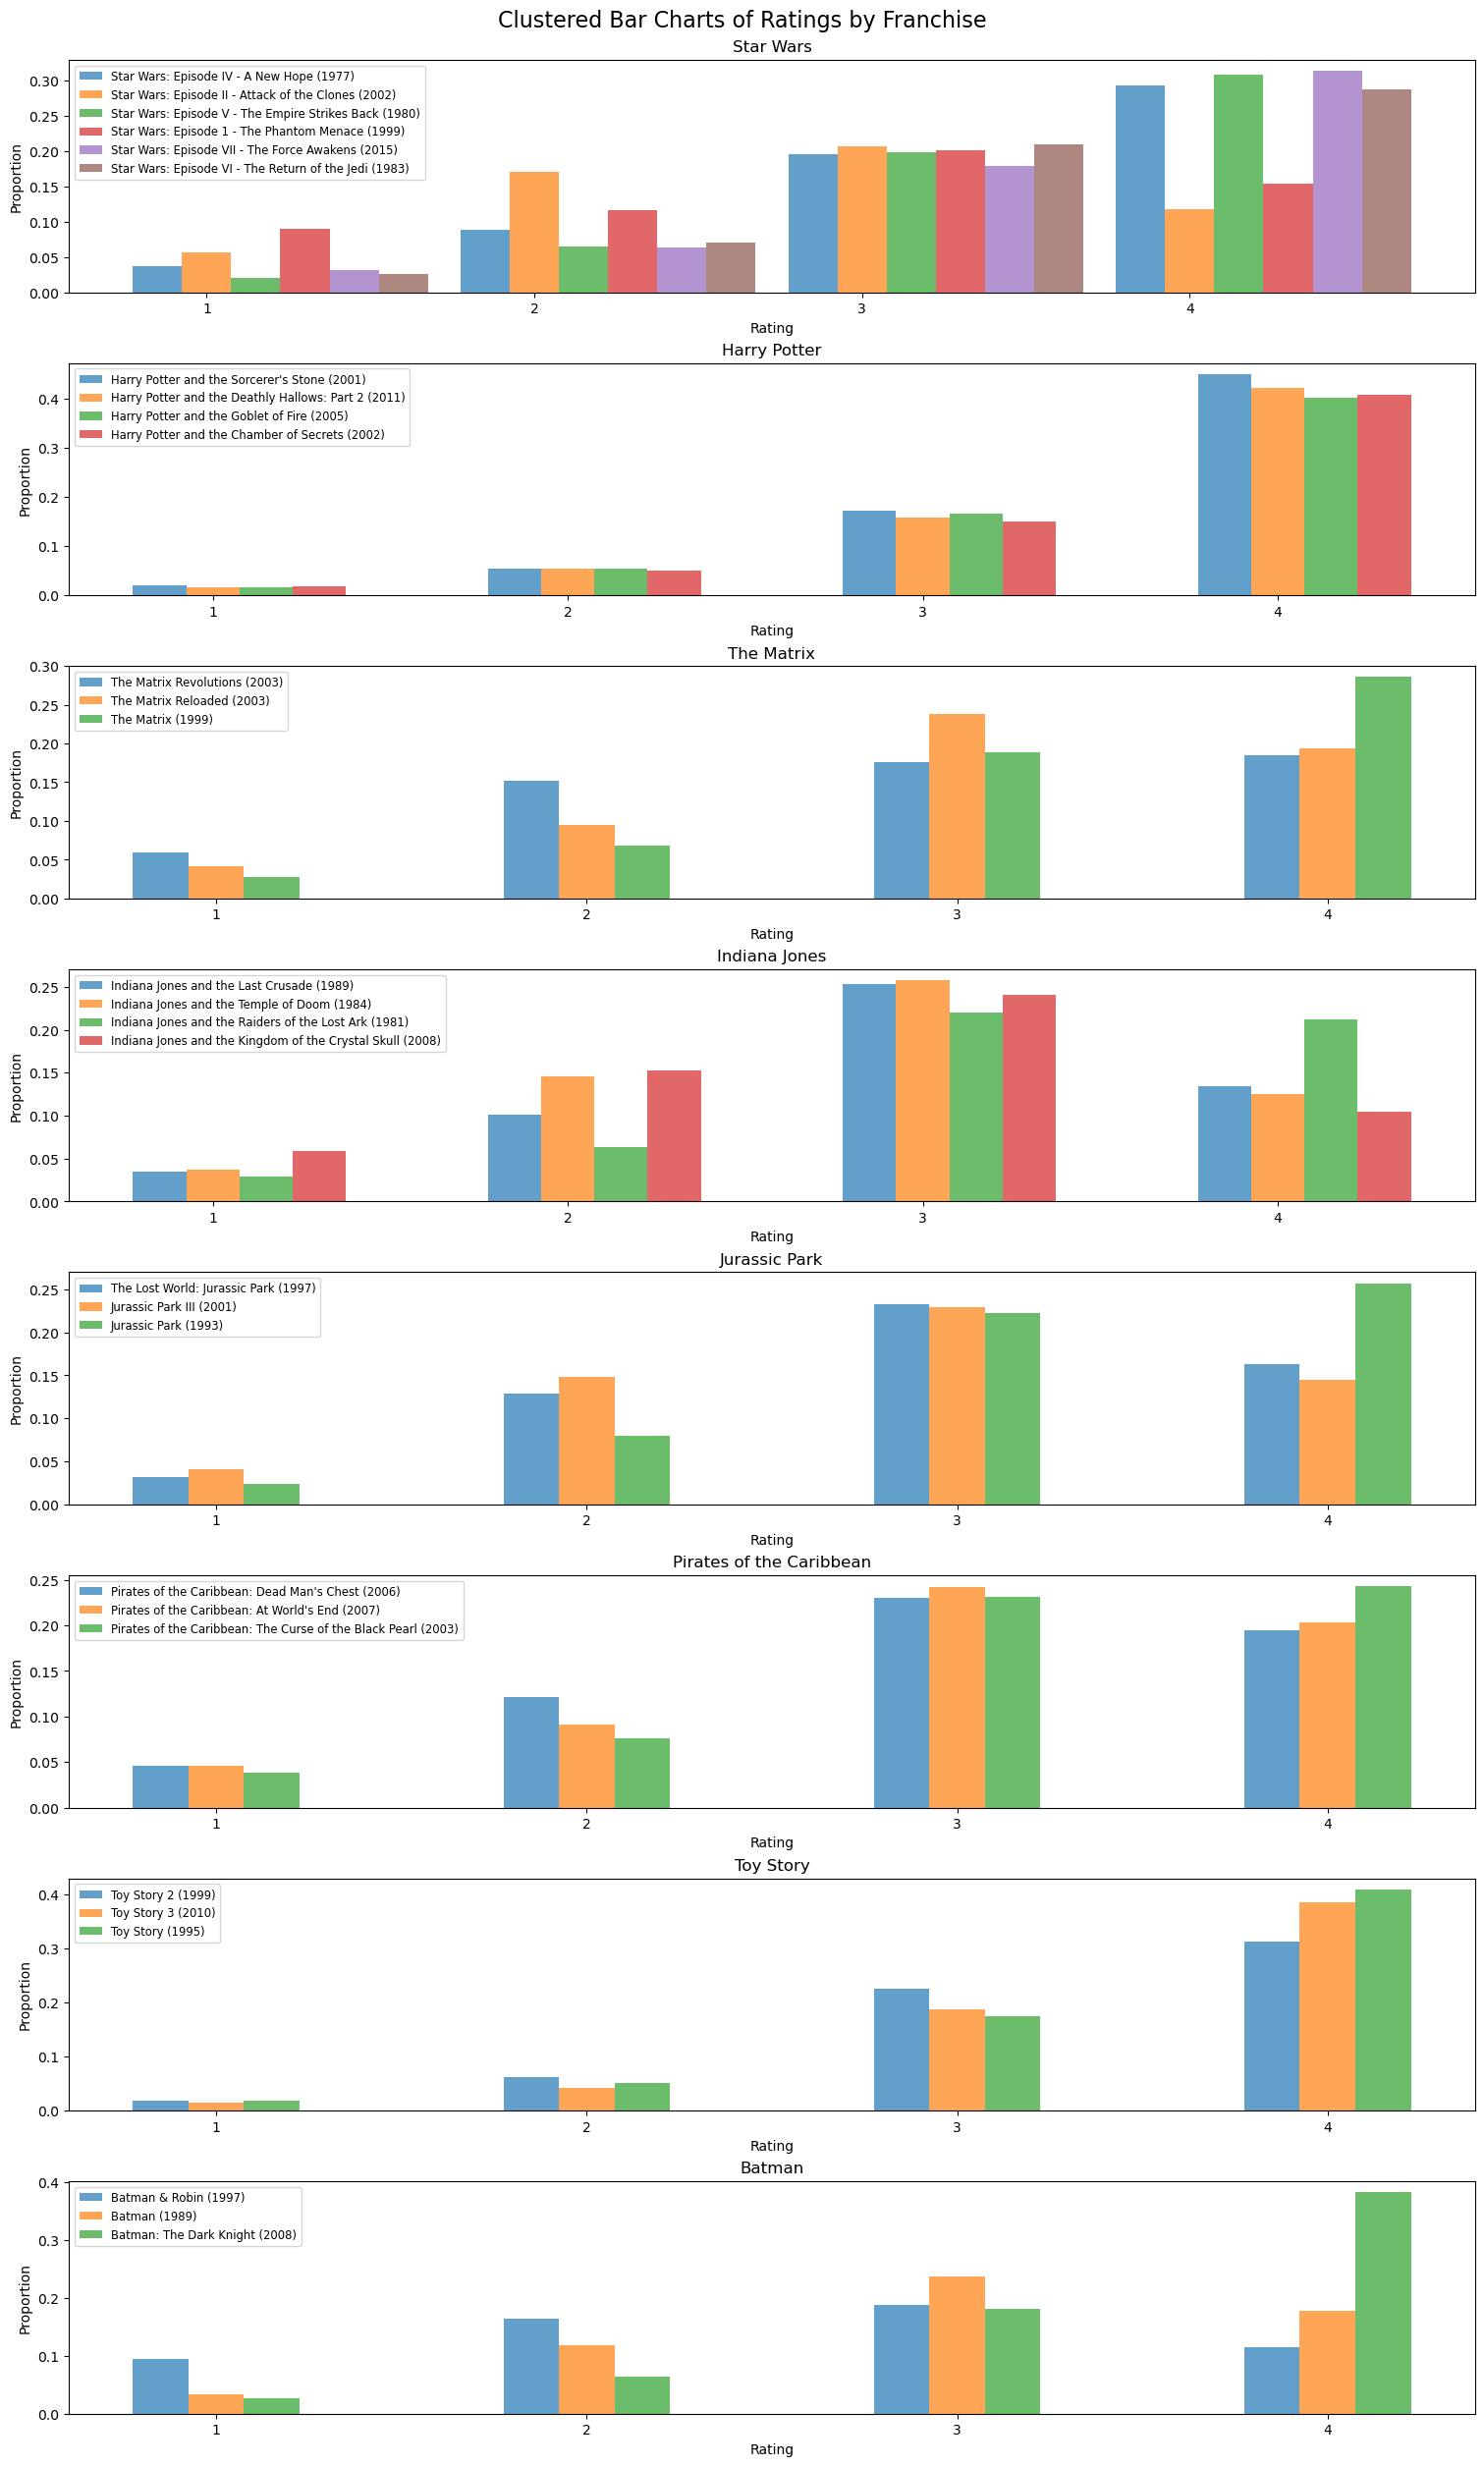

In [336]:
# Plot clustered bar charts for each franchise
fig, axs = plt.subplots(len(franchises), 1, figsize=(15, 25), constrained_layout=True)
fig.suptitle('Clustered Bar Charts of Ratings by Franchise', fontsize=16)

# Generate plots
for ax, (franchise, movies) in zip(axs, franchises.items()):
    ax.set_title(franchise)
    bar_width = 0.15
    positions = list(range(1, 5))  

    # Loop through each movie in the franchise to create bars
    for idx, movie in enumerate(movies):
        if movie in df_10.columns:
            ratings = df_10[movie].dropna()
            ratings_proportion = ratings.value_counts(normalize=True).sort_index()
            offset_positions = [p + bar_width * idx for p in positions] 
            
            # Plotting each movie's bar in the cluster
            ax.bar(offset_positions, ratings_proportion.reindex(positions, fill_value=0), 
                   width=bar_width, label=movie, alpha=0.7)
    
    ax.set_xlabel('Rating')
    ax.set_ylabel('Proportion')
    ax.set_xticks([p + bar_width for p in positions])
    ax.set_xticklabels(positions)
    ax.legend(loc='upper left', fontsize='small')

plt.show()



In [337]:
# Dictionary to store overall effect sizes for each franchise
overall_effect_sizes = {}

# Loop through each franchise
for franchise, movies in franchises.items():
    # Collect ratings for each movie in the franchise
    franchise_ratings = [df_10[movie].dropna() for movie in movies]
    
    # Perform Kruskal-Wallis test for significance
    if len(franchise_ratings) > 1:  # Ensure at least 2 movies for comparison
        kruskal_stat, p_value = kruskal(*franchise_ratings)
        
        # Calculate total number of ratings (N) and number of movies (k)
        N = sum(len(ratings) for ratings in franchise_ratings)
        k = len(franchise_ratings)
        
        # Calculate Epsilon-Squared (overall effect size for the franchise)
        epsilon_squared = (kruskal_stat - k + 1) / (N - k)
        overall_effect_sizes[franchise] = epsilon_squared
        
        # # Print the overall effect size
        # print(f"{franchise}: Kruskal-Wallis Statistic = {kruskal_stat:.4f}, p-value = {p_value:.4f}")
        # print(f"Overall Effect Size (Epsilon-Squared) = {epsilon_squared:.4f}\n")

# Summary of Overall Effect Sizes for Each Franchise
print("\nOverall Effect Size Summary for Each Franchise:")
for franchise, epsilon in overall_effect_sizes.items():
    print(f"{franchise}: Epsilon-Squared = {epsilon:.4f}")





Overall Effect Size Summary for Each Franchise:
Star Wars: Epsilon-Squared = 0.0764
Harry Potter: Epsilon-Squared = 0.0001
The Matrix: Epsilon-Squared = 0.0385
Indiana Jones: Epsilon-Squared = 0.0246
Jurassic Park: Epsilon-Squared = 0.0263
Pirates of the Caribbean: Epsilon-Squared = 0.0087
Toy Story: Epsilon-Squared = 0.0083
Batman: Epsilon-Squared = 0.1304
